# Eddy Current Brake
This script is to replicate the analytical plot in Fig. 6 of the 2019 journal paper 'Characteristic Analysis of the Peak Braking Force and the Critical Speed of Eddy Current Braking in a High-Speed Maglev' authored by Chuntao Chen, Jie Xu, Xibo Yuan and Xinzhen Wu. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Constants
MU0 = 4 * np.pi * 10 ** (-7)  # Permeability of free space in H/m

# Model parameters
pole_pairs = 6  # Number of pole pairs (no unit)
velocity_max = 272  # Maximum operating speed in m/s
current_density = 1.2 * 10 ** 7  # Exciting current density in A/m2
fill_factor = 0.687  # Fill factor of coil slot (no unit)
coil_width = 0.0153  # Width of exciting coil in m
coil_height = 0.115  # Height of exciting coil in m
pole_pitch = 0.1  # Pole pitch in m
air_gap = 0.01  # Air gap length in m
pole_width = 0.0692  # Pole width in m
plate_thickness = 0.005  # Thickness of induction plate in m
model_depth = 0.2  # Model depth in m
conductivity = [
    5 * 10 ** 5,
    10 ** 6,
    2 * 10 ** 7,
]  # Induction plate conductivity in S/m

# Variables
velocity = np.linspace(0, velocity_max, 5000)  # Velocity in m/s
no = np.array([1, 3])  # Number of harmonic (no unit)

## Calculate Carter coefficient and modified air gap length

In [3]:
coef = (pole_pitch - pole_width) / (2 * air_gap)  # Sumarise quotient for use below
gamma = 4 / np.pi * (coef * np.arctan(coef) - np.log(np.sqrt(1 + coef ** 2)))
carter_coef = pole_pitch / (
    pole_pitch - gamma * air_gap
)  # Carter coefficient (no unit)
air_gap_modified = air_gap * carter_coef  # Modified air gap length in m

## Calculate the total length of eddy current braking device 

In [4]:
total_length = 2 * pole_pairs * pole_pitch  # Total length in m

## Calculate components of the Fourier decomposition and the nth harmonic of the braking force

In [5]:
def calc_area(coil_height, coil_width, fill_factor):
    """Calculate cross-sectional area of exciting coil in m**2.
    Inputs:
    coil_height ... Height of exciting coil in m
    coil_width ... Width of exciting coil in m
    fill_factor ... Fill factor of coil slot (no unit)"""
    return coil_height * coil_width * fill_factor


def calc_coil_gap(pole_pitch, coil_width, pole_width):
    """Calculate gap between coils in m.
    Inputs:
    pole_pitch ... Pole pitch in m
    coil_width ... Width of exciting coil in m
    pole_width ... Pole width in m
    """
    return pole_pitch - (2 * coil_width + pole_width)


def calc_linear_current_density_constant(
    current_density, area, fill_factor, coil_width
):
    """Calculates the linear current density constant in A/m.
    Inputs:
    current_density ... Exciting current density in A/m2
    area ... Cross-sectional area of exciting coil in m**2
    fill_factor ... Fill factor of coil slot (no unit)
    coil_with ... Width of exciting coil in m"""
    return current_density * area * fill_factor / coil_width


def integ(upper, lower):
    """Calculates a definite integral of the form occuring
    in equation 15 in a specified inteval.
    Inputs:
    upper ... upper boundary of the interval
    lower ... lower boundary of the interval
    """
    return 1 / npitau * (np.sin(npitau * upper) - np.sin(npitau * lower))


brake_force = np.zeros([len(velocity), len(conductivity)])
brake_force_store = np.zeros([len(no), len(velocity), len(conductivity)])

coil_gap = calc_coil_gap(pole_pitch, coil_width, pole_width)
linear_current_density_const = calc_linear_current_density_constant(
    current_density,
    calc_area(coil_height, coil_width, fill_factor),
    fill_factor,
    coil_width,
)

for sigma in range(0, len(conductivity)):
    for idx in range(0, len(no)):
        npitau = no[idx] * np.pi / pole_pitch  # Sumarise quotient for later use
        k = (
            np.pi
            / pole_pitch
            * (
                integ(coil_gap / 2 + coil_width, coil_gap / 2)
                - integ(
                    pole_pitch - coil_gap / 2, pole_pitch - (coil_gap / 2 + coil_width)
                )
            )
        )
        an = 2 * linear_current_density_const * k / np.pi

        # Calculate the nth harmonic of the braking force

        summand = npitau * np.sqrt(
            npitau ** 2 + MU0 ** 2 * conductivity[sigma] ** 2 * velocity ** 2
        )
        m = np.sqrt((npitau ** 2 + summand) / 2)
        n = np.sqrt((-(npitau ** 2) + summand) / 2)

        y1 = (
            np.cosh(npitau * air_gap_modified)
            * np.sinh(m * plate_thickness)
            * np.cos(n * plate_thickness)
        )
        y2 = (
            np.cosh(npitau * air_gap_modified)
            * np.cosh(m * plate_thickness)
            * np.sin(n * plate_thickness)
        )
        y3 = (
            np.sinh(npitau * air_gap_modified)
            * np.cosh(m * plate_thickness)
            * np.cos(n * plate_thickness)
        )
        y4 = (
            np.sinh(npitau * air_gap_modified)
            * np.sinh(m * plate_thickness)
            * np.sin(n * plate_thickness)
        )

        brake_force_harmonic = -(
            npitau
            * total_length
            * model_depth
            * MU0
            * an ** 2
            * (
                m * np.sin(2 * n * plate_thickness)
                + n * np.sinh(2 * m * plate_thickness)
            )
        ) / (
            2
            * (
                (m * y1 - n * y2 + npitau * y3) ** 2
                + (m * y2 + n * y1 + npitau * y4) ** 2
            )
        )
        brake_force_store[idx, :, sigma] = brake_force_harmonic
        brake_force[:, sigma] = brake_force[:, sigma] + brake_force_store[idx, :, sigma]
    print(
        "Max brakeforce magnitude for a conductivity of {} S/m:".format(
            conductivity[sigma]
        ),
        abs(round(brake_force_store[0, :, sigma].min(), 2)),
        "N",
    )

Max brakeforce magnitude for a conductivity of 500000 S/m: 38293.36 N
Max brakeforce magnitude for a conductivity of 1000000 S/m: 38293.36 N
Max brakeforce magnitude for a conductivity of 20000000 S/m: 38293.33 N


## Import extracted data from paper and compare to calculated results
Data has been extracted via Web Plot Digitizer

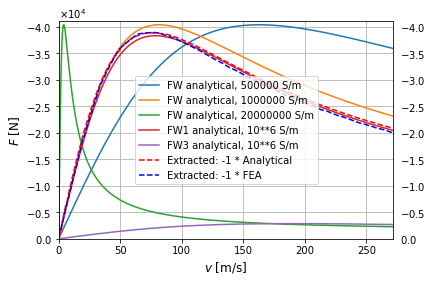

In [6]:
ana = pd.read_csv(
    "figure6_AnalyticalSolution_WebPlotDigitizer_AutomaticExtraction_Win10px10px.csv"
)
fea = pd.read_csv(
    "figure6_FEASolution_WebPlotDigitizer_AutomaticExtraction_Win10px10px.csv"
)

xtitle = "$v$ [m/s]"
ytitle = "$F$ [N]"

fig, ax = plt.subplots(nrows=1, ncols=1)
for sigma in range(0, len(conductivity)):
    ax.plot(
        velocity,
        brake_force[:, sigma],
        label="FW analytical, {} S/m".format(conductivity[sigma]),
    )
for idx in range(0, len(no)):
    ax.plot(
        velocity,
        brake_force_store[idx, :, 1],
        label="FW{} analytical, 10**6 S/m".format(no[idx]),
    )
ax.plot(
    ana["v"],
    -ana["F"],
    color="red",
    linestyle="dashed",
    label="Extracted: -1 * Analytical ",
)
ax.plot(
    fea["v"], -fea["F"], color="blue", linestyle="dashed", label="Extracted: -1 * FEA"
)
ax.set_xlabel(xtitle, fontsize="large")
ax.set_ylabel(ytitle, fontsize="large")
ax.set_xlim([0, velocity_max])
ax.set_ylim([0, -4.1 * 10 ** 4])
ax.legend()
ax.grid()
ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0), useMathText=True)
ax.tick_params(labelright=True)

In this model the conductivity has no influence on the brake force.

But the conductivity affects the critical speed. The lower the conductivity the higher the critical speed.

## Create polynomial fits for the 1st harmonic 
Compare them to analytical result

Plot the % errors between analytical and fitted curves

Consider only conductivity of 10**6 S/m

Skip first element to avoid division by 0

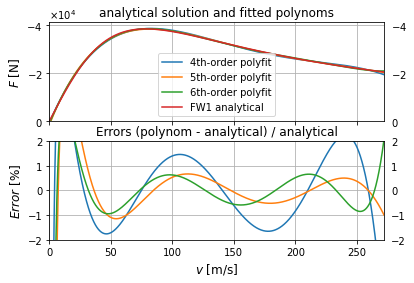

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ytitle = "$F$ [N]"
ax1.set_title("analytical solution and fitted polynoms")
for idx in range(4, 7):
    fitcoef = np.polyfit(velocity, brake_force_store[0, :, 1], idx)
    fit = np.poly1d(fitcoef)
    ax1.plot(velocity, fit(velocity), label="{}th-order polyfit".format(idx))
    ax2.plot(
        velocity[1:],
        (fit(velocity[1:]) - brake_force_store[0, 1:, 1])
        / brake_force_store[0, 1:, 1]
        * 100,
        label="{}th order polyfit - FW1".format(idx),
    )

ax1.plot(velocity, brake_force_store[0, :, 1], label="FW1 analytical")
ax1.set_ylabel(ytitle, fontsize="large")
ax1.set_xlim([0, velocity_max])
ax1.set_ylim([0, -4.1 * 10 ** 4])
ax1.legend()
ax1.grid()
ax1.ticklabel_format(style="sci", axis="y", scilimits=(0, 0), useMathText=True)
ax1.tick_params(labelright=True)

ytitle = "$Error$ [%]"
ax2.set_title("Errors (polynom - analytical) / analytical")
ax2.set_ylabel(ytitle, fontsize="large")
ax2.set_xlabel(xtitle, fontsize="large")
ax2.set_ylim([-2, 2])
ax2.grid()
ax2.tick_params(labelright=True)